# Lightgbm

In [2]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

import lightgbm

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler

from IPython.display import display

from utils import *

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load data

In [4]:
train = pd.read_csv('input/train.csv')
print(train.shape)

(307511, 199)


In [5]:
#display(train.head(2))

In [6]:
test = pd.read_csv('input/test.csv')
print(test.shape)

(48744, 198)


### Load possible outliers (Optional)

In [3]:
outliers_idx = np.load('isolation_forest_outliers.npy', mmap_mode='r')
outliers_idx = np.array(outliers_idx)

Outliers removal (optional step)

In [ ]:
train = train.drop(index=train.index[outliers_idx])
train = train.reset_index(drop=True)

Removing service and target columns

In [7]:
targets = train[['TARGET']]

train_ids = train['SK_ID_CURR']
train = train.drop(columns=['SK_ID_CURR', 'TARGET'])

In [8]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [9]:
targets.shape

(307511, 1)

### Drop redundant columns
Columns which almost identical (correlation is close to 1)

In [10]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [11]:
print(train.shape)
print(test.shape)

(307511, 177)
(48744, 177)


### List Categorical Features

In [12]:
cat_features = train.select_dtypes('object').columns.tolist()

In [13]:
for col in cat_features: 
    train[col] = train[col].astype('category') 
    test[col] = test[col].astype('category') 

### Parameter Tuning

In [15]:
best_params = {
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 10000,
    'num_leaves': 32,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5
}

params = {
    'learning_rate': [0.05],
    'n_estimators': [10000],
    'num_leaves': [32, 64],
    'max_depth': [-1, 7],
    'min_child_samples': [80, 160],
    'reg_alpha': [2.0, 4.0],
    'reg_lambda': [1.0, 2.0],
    'max_bin': [255]
}

# rscv = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=1, verbose=1)
# rscv.fit(train, targets[['TARGET']], categorical_feature=cat_features,
#          eval_metric='auc', verbose=100)
cv_results = []

for i, param_smple in enumerate(list(ParameterSampler(params, 10))):
    print('Iteration %i, params: %s' % (i, param_smple))
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []
    train_scores = []
    params_ = dict(param_smple)
    params_['params'] = param_smple
    start = time.time()
    fold_i = 0
    model = lightgbm.LGBMClassifier(n_estimators=param_smple['n_estimators'], objective='binary', 
                                    class_weight='balanced', learning_rate=param_smple['learning_rate'], 
                                    num_leaves=param_smple['num_leaves'], max_depth=param_smple['max_depth'],
                                    reg_alpha=param_smple['reg_alpha'], reg_lambda=param_smple['reg_lambda'], 
                                    min_child_samples=param_smple['min_child_samples'],
                                    subsample=0.8, n_jobs=6, random_state=4242, max_bin=param_smple['max_bin'])
    
    for train_indices, valid_indices in k_fold.split(train, targets):
        train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
        valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    
        model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                      eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                      eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        params_['train_score_%s' % fold_i] = model.best_score_['train']['auc']
        params_['valid_score_%s' % fold_i] = model.best_score_['valid']['auc']
        fold_i += 1
    
    end = time.time()
    params_['fit_time'] = end - start
    params_['mean_train_score'] = np.mean(train_scores)
    params_['mean_valid_score'] = np.mean(valid_scores)
    cv_results.append(params_)
    

Iteration 0, params: {'max_depth': 7, 'learning_rate': 0.05, 'num_leaves': 32, 'reg_lambda': 2.0, 'n_estimators': 10000, 'max_bin': 255, 'reg_alpha': 4.0, 'min_child_samples': 80}
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799395	valid's auc: 0.765144
[200]	train's auc: 0.825386	valid's auc: 0.772813
[300]	train's auc: 0.844485	valid's auc: 0.774921
[400]	train's auc: 0.860025	valid's auc: 0.775358
[500]	train's auc: 0.873535	valid's auc: 0.775464
[600]	train's auc: 0.885917	valid's auc: 0.775596
Early stopping, best iteration is:
[555]	train's auc: 0.880612	valid's auc: 0.77574
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.798488	valid's auc: 0.767914
[200]	train's auc: 0.824301	valid's auc: 0.774598
[300]	train's auc: 0.843218	valid's auc: 0.776464
[400]	train's auc: 0.859115	valid's auc: 0.776663
Early stopping, best iteration is:
[376]	train's auc: 0.855431	valid's auc: 0.776956
Training until validation

[100]	train's auc: 0.828543	valid's auc: 0.77064
[200]	train's auc: 0.86904	valid's auc: 0.776138
[300]	train's auc: 0.897393	valid's auc: 0.776528
Early stopping, best iteration is:
[292]	train's auc: 0.895344	valid's auc: 0.776776
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828881	valid's auc: 0.771527
[200]	train's auc: 0.869424	valid's auc: 0.776055
[300]	train's auc: 0.897456	valid's auc: 0.775831
Early stopping, best iteration is:
[211]	train's auc: 0.873181	valid's auc: 0.77617
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828623	valid's auc: 0.769925
[200]	train's auc: 0.869602	valid's auc: 0.774022
[300]	train's auc: 0.897497	valid's auc: 0.77358
Early stopping, best iteration is:
[223]	train's auc: 0.876793	valid's auc: 0.774418
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828713	valid's auc: 0.771929
[200]	train's auc: 0.869343	valid's auc: 0.776336
[300]	trai

[300]	train's auc: 0.847184	valid's auc: 0.777371
Early stopping, best iteration is:
[261]	train's auc: 0.83992	valid's auc: 0.777561
Iteration 9, params: {'max_depth': 7, 'learning_rate': 0.05, 'num_leaves': 32, 'reg_lambda': 1.0, 'n_estimators': 10000, 'max_bin': 255, 'reg_alpha': 4.0, 'min_child_samples': 80}
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799299	valid's auc: 0.765324
[200]	train's auc: 0.825003	valid's auc: 0.772993
[300]	train's auc: 0.843875	valid's auc: 0.775043
[400]	train's auc: 0.859915	valid's auc: 0.77536
[500]	train's auc: 0.873677	valid's auc: 0.774751
Early stopping, best iteration is:
[427]	train's auc: 0.864019	valid's auc: 0.775476
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799251	valid's auc: 0.768471
[200]	train's auc: 0.82481	valid's auc: 0.775481
[300]	train's auc: 0.843495	valid's auc: 0.776877
[400]	train's auc: 0.859298	valid's auc: 0.777335
[500]	train's auc: 0.873271

In [19]:
df_results = pd.DataFrame(cv_results)
df_results.sort_values('mean_valid_score', axis=0)

,fit_time,learning_rate,max_bin,max_depth,mean_train_score,mean_valid_score,min_child_samples,n_estimators,num_leaves,params,reg_alpha,reg_lambda,train_score_0,train_score_1,train_score_2,train_score_3,train_score_4,valid_score_0,valid_score_1,valid_score_2,valid_score_3,valid_score_4
2,209.345991,0.05,255,7,0.879643,0.774872,160,10000,64,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,1.0,0.884810,0.878929,0.870778,0.883375,0.880324,0.773982,0.775994,0.775934,0.773367,0.775080
4,221.092630,0.05,255,-1,0.884262,0.775698,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,1.0,0.891202,0.895344,0.873181,0.876793,0.884790,0.774554,0.776776,0.776170,0.774418,0.776569
7,230.559262,0.05,255,-1,0.886008,0.775903,160,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,1.0,0.885867,0.880709,0.900700,0.870250,0.892515,0.775475,0.776003,0.776658,0.774745,0.776636
5,219.593719,0.05,255,-1,0.881182,0.775955,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,1.0,0.892885,0.882636,0.872181,0.884327,0.873883,0.775252,0.776981,0.776253,0.774913,0.776378
3,243.125517,0.05,255,-1,0.888726,0.776094,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,2.0,0.903517,0.900325,0.869330,0.892090,0.878368,0.775331,0.776650,0.776021,0.774950,0.777520
6,227.609989,0.05,255,-1,0.862194,0.776147,160,10000,32,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,1.0,0.873431,0.859316,0.880181,0.851305,0.846737,0.775149,0.777162,0.777237,0.774826,0.776359
9,220.591223,0.05,255,7,0.853910,0.776186,80,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,1.0,0.864019,0.859661,0.842670,0.856077,0.847123,0.775476,0.777402,0.776402,0.774785,0.776862
8,205.577855,0.05,255,-1,0.850824,0.776347,160,10000,32,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,2.0,0.861142,0.847452,0.862335,0.843271,0.839920,0.776083,0.777526,0.776533,0.774035,0.777561
0,209.558289,0.05,255,7,0.855997,0.776403,80,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,2.0,0.880612,0.855431,0.845372,0.845025,0.853547,0.775740,0.776956,0.777227,0.774894,0.777196
1,226.068312,0.05,255,7,0.859351,0.776409,160,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",2.0,2.0,0.851097,0.873188,0.866143,0.843619,0.862705,0.775473,0.777569,0.776632,0.774995,0.777378


In [20]:
best_index = df_results.mean_valid_score.idxmax()
df_results.iloc[best_index]['params']

{'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 7,
 'min_child_samples': 160,
 'n_estimators': 10000,
 'num_leaves': 32,
 'reg_alpha': 2.0,
 'reg_lambda': 2.0}

In [21]:
df_results.iloc[best_index]

fit_time                                                       226.068
learning_rate                                                     0.05
max_bin                                                            255
max_depth                                                            7
mean_train_score                                              0.859351
mean_valid_score                                              0.776409
min_child_samples                                                  160
n_estimators                                                     10000
num_leaves                                                          32
params               {'max_depth': 7, 'learning_rate': 0.05, 'num_l...
reg_alpha                                                            2
reg_lambda                                                           2
train_score_0                                                 0.851097
train_score_1                                                 0.873188
train_

### Model K-Fold Execution

In [22]:
features = np.array(train)
test_features = np.array(test)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

valid_scores = []
train_scores = []
test_predictions = np.zeros(test_features.shape[0])

model = lightgbm.LGBMClassifier(n_estimators=32000, objective='binary', 
                                class_weight='balanced', learning_rate=0.005, 
                                num_leaves=32, max_depth=7,
                                reg_alpha=3, reg_lambda=3,
                                min_child_sample=160,
                                subsample=0.8, n_jobs=6, random_state=4242)

for train_indices, valid_indices in k_fold.split(features, targets):
    # Numpy version
    # Training data for the fold
    #train_features, train_labels = features[train_indices], targets[train_indices]
    # Validation data for the fold
    #valid_features, valid_labels = features[valid_indices], targets[valid_indices]
    
    # DataFrame version
    train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
    valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    test_features = test
    
    # d_train = lightgbm.Dataset(train_features, label=train_labels)
    # d_valid = lightgbm.Dataset(valid_features, label=valid_labels)
    # model = lightgbm.train(parameters, d_train, verbose_eval=100, valid_sets=[d_valid], num_boost_round=20000, early_stopping_rounds=200)
    
    # The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional
    # to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    
    model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

    best_iteration = model.best_iteration_
    
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.741204	valid's auc: 0.726213
[200]	train's auc: 0.749218	valid's auc: 0.73299
[300]	train's auc: 0.758892	valid's auc: 0.740054
[400]	train's auc: 0.768403	valid's auc: 0.746831
[500]	train's auc: 0.776552	valid's auc: 0.752642
[600]	train's auc: 0.78281	valid's auc: 0.756627
[700]	train's auc: 0.787832	valid's auc: 0.75936
[800]	train's auc: 0.792189	valid's auc: 0.761589
[900]	train's auc: 0.796235	valid's auc: 0.7637
[1000]	train's auc: 0.799895	valid's auc: 0.76538
[1100]	train's auc: 0.803242	valid's auc: 0.766775
[1200]	train's auc: 0.806287	valid's auc: 0.768016
[1300]	train's auc: 0.809072	valid's auc: 0.76904
[1400]	train's auc: 0.811726	valid's auc: 0.76987
[1500]	train's auc: 0.814356	valid's auc: 0.770628
[1600]	train's auc: 0.816807	valid's auc: 0.771246
[1700]	train's auc: 0.819228	valid's auc: 0.771784
[1800]	train's auc: 0.821474	valid's auc: 0.772283
[1900]	train's auc: 0.823656	valid's

[1200]	train's auc: 0.805277	valid's auc: 0.771834
[1300]	train's auc: 0.80816	valid's auc: 0.772728
[1400]	train's auc: 0.810895	valid's auc: 0.773451
[1500]	train's auc: 0.813488	valid's auc: 0.774031
[1600]	train's auc: 0.815953	valid's auc: 0.774558
[1700]	train's auc: 0.81835	valid's auc: 0.774982
[1800]	train's auc: 0.820629	valid's auc: 0.775445
[1900]	train's auc: 0.822876	valid's auc: 0.775759
[2000]	train's auc: 0.825023	valid's auc: 0.776042
[2100]	train's auc: 0.827094	valid's auc: 0.776297
[2200]	train's auc: 0.829122	valid's auc: 0.776525
[2300]	train's auc: 0.831059	valid's auc: 0.776746
[2400]	train's auc: 0.833013	valid's auc: 0.776987
[2500]	train's auc: 0.834959	valid's auc: 0.777153
[2600]	train's auc: 0.836825	valid's auc: 0.777281
[2700]	train's auc: 0.838653	valid's auc: 0.777385
[2800]	train's auc: 0.84045	valid's auc: 0.777396
[2900]	train's auc: 0.842161	valid's auc: 0.777454
[3000]	train's auc: 0.843905	valid's auc: 0.777491
[3100]	train's auc: 0.845596	valid

### Plots

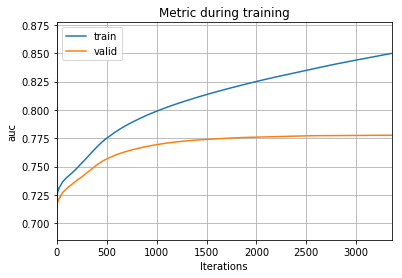

In [23]:
lightgbm.plot_metric(model)

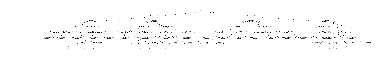

In [24]:
lightgbm.plot_tree(model)

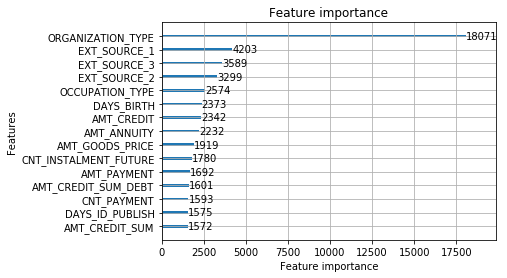

In [25]:
lightgbm.plot_importance(model, max_num_features=15)

### Submission

In [26]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'lightgbm')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-lightgbm.csv -m "lightgbm"'